This notebook is a tutorial for performing data integration across large scale studies, using a subset of data from the COVID single-cell sequencing data published by <a href="https://www.nature.com/articles/s41591-021-01329-2">Haniffa et al</a>.

# Imports

In [3]:
import scanpy as sc
import numpy as np
import pandas as pd 

import time


# Plotting 
import matplotlib.pyplot as plt
import seaborn as sns

# Load COVID patient anndatas

These are anndatas corresponding to single cell measurements for 20 patients - 10 COVID/Critical and 10 Healthy. SEACells have been pre-computed for these datasets and can be accessed at `.obs['SEACell']`

In [ ]:
# !mkdir data/  
# !wget https://dp-lab-data-public.s3.amazonaws.com/SEACells/covid_pbmcs.h5ad -O data/covid_pbmcs.h5ad

In [34]:
# Read in anndata file containing single cells from 6 different patients
covid_pbmcs = sc.read('data/covid_pbmcs.h5ad')

# List the samples present
list(covid_pbmcs.obs['sample'].unique())

['MH8919226',
 'MH8919282',
 'BGCV13_CV0934',
 'MH8919333',
 'BGCV04_CV0911',
 'MH8919332',
 'BGCV14_CV0940',
 'newcastle74',
 'BGCV01_CV0902',
 'BGCV12_CV0926',
 'BGCV08_CV0201',
 'BGCV09_CV0279',
 'MH8919328',
 'MH8919329',
 'BGCV11_CV0180',
 'BGCV06_CV0201',
 'newcastle004v2',
 'MH9143277',
 'newcastle21',
 'AP2']

In [33]:
covid_pbmcs.obs[['sample','Status_on_day_collection_summary','SEACell']].head()

,sample,Status_on_day_collection_summary,SEACell
covid_index,,,
AAACCTGCAAGAAGAG-MH8919226,MH8919226,Healthy,CGGACACTCTGCAGTA-MH8919226
AACTCAGAGACAGACC-MH8919226,MH8919226,Healthy,CGGACACTCTGCAGTA-MH8919226
AAGCCGCAGTTAAGTG-MH8919226,MH8919226,Healthy,CGGACACTCTGCAGTA-MH8919226
AAGGAGCTCTCCAGGG-MH8919226,MH8919226,Healthy,CGGACACTCTGCAGTA-MH8919226
AAGGTTCAGATCTGCT-MH8919226,MH8919226,Healthy,CGGACACTCTGCAGTA-MH8919226


## Visualization of Multiple Samples is Time Consuming with Single Cells

In [35]:
# s = time.time()

# covid_pbmcs.X = covid_pbmcs.layers['raw']
# sc.pp.normalize_total(covid_pbmcs)
# sc.pp.log1p(covid_pbmcs)
# sc.pp.highly_variable_genes(covid_pbmcs, batch_key='sample', n_top_genes=2500, inplace=True)

# sc.tl.pca(covid_pbmcs, use_highly_variable=True)
# sc.pp.neighbors(covid_pbmcs, use_rep='X_pca')
# sc.tl.umap(covid_pbmcs)

# print(time.time()-s)

/Users/sitarapersad/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2492: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/sitarapersad/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/sitarapersad/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2492: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


175.00490713119507


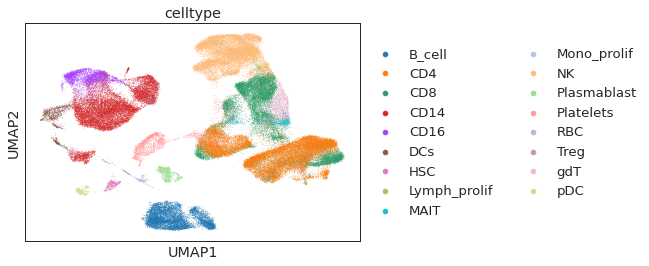

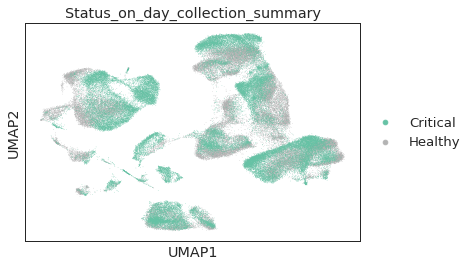

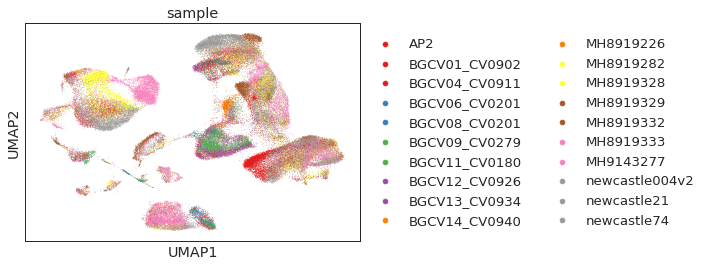

In [36]:
sc.pl.umap(covid_pbmcs, color='celltype')
sc.pl.umap(covid_pbmcs, color='Status_on_day_collection_summary', palette='Set2')
sc.pl.umap(covid_pbmcs, color='sample', palette='Set1')

## Summarize patients by SEACell 
This yields compact, aggregated SEACell x gene anndatas for each patient

In [37]:
from SEACells.core import summarize_by_SEACell

ad = summarize_by_SEACell(covid_pbmcs, SEACells_label='SEACell')
ad.layers['raw'] = ad.X

/Users/sitarapersad/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2492: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [38]:
# We now have a summarized matrix of dimension # SEACells x genes

f'Number of SEACells: {covid_pbmcs.obs["SEACell"].unique().shape[0]}, Dimension of anndata: {ad.shape}'


'Number of SEACells: 1174, Dimension of anndata: (1174, 24737)'

In [39]:
# Annotate summarized anndata with .obs information from the original single cell data

ad.obs['sample'] = covid_pbmcs.obs.loc[ad.obs_names, 'sample']
ad.obs['# Single Cells'] = covid_pbmcs.obs.groupby('SEACell').count().iloc[:,0].loc[ad.obs_names]
ad.obs['Status_on_day_collection_summary'] = covid_pbmcs.obs.loc[ad.obs_names, 'Status_on_day_collection_summary']
ad.obs['celltype'] = covid_pbmcs.obs.loc[ad.obs_names, 'celltype']

ad.obs.head()


,sample,# Single Cells,Status_on_day_collection_summary,celltype
CGGACACTCTGCAGTA-MH8919226,MH8919226,84,Healthy,NK
CGCTTCAGTAAAGTCA-MH8919226,MH8919226,89,Healthy,NK
CACATTTCAATCTGCA-MH8919226,MH8919226,99,Healthy,CD14
GGGACCTGTAAGGATT-MH8919226,MH8919226,54,Healthy,B_cell
AGACGTTAGTGACTCT-MH8919226,MH8919226,36,Healthy,B_cell


In [40]:
sc.pp.normalize_total(ad)
sc.pp.log1p(ad)
sc.pp.highly_variable_genes(ad, batch_key='sample', n_top_genes=2500, inplace=True)

sc.tl.pca(ad, use_highly_variable=True)
sc.pp.neighbors(ad, use_rep='X_pca')
sc.tl.umap(ad)

/Users/sitarapersad/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2492: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/sitarapersad/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/sitarapersad/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2492: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


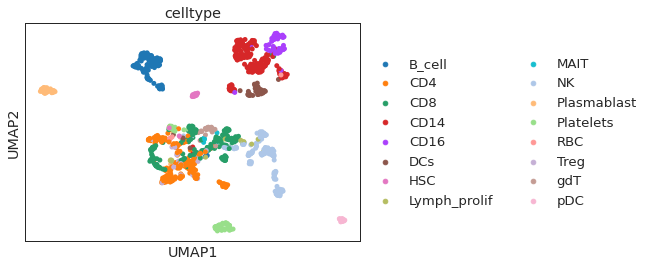

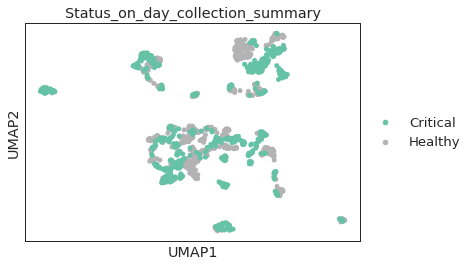

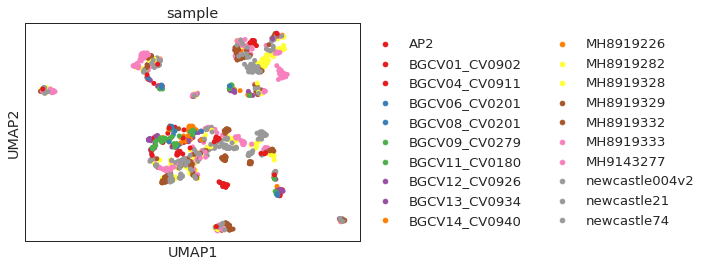

In [41]:
%matplotlib inline
sc.pl.umap(ad, color='celltype', s=100)
sc.pl.umap(ad, color='Status_on_day_collection_summary', palette='Set2', s=100)
sc.pl.umap(ad, color='sample', palette='Set1', s=100)


# SEA2Cell Aggregation Across Patients

## Batch Correction 

In [42]:
# Perform batch correction to account for differences between samples.
sc.external.pp.harmony_integrate(ad, 'sample')

2022-03-30 21:06:42,184 - harmonypy - INFO - Iteration 1 of 10
2022-03-30 21:06:42,393 - harmonypy - INFO - Iteration 2 of 10
2022-03-30 21:06:42,548 - harmonypy - INFO - Iteration 3 of 10
2022-03-30 21:06:42,702 - harmonypy - INFO - Iteration 4 of 10
2022-03-30 21:06:42,766 - harmonypy - INFO - Iteration 5 of 10
2022-03-30 21:06:42,877 - harmonypy - INFO - Iteration 6 of 10
2022-03-30 21:06:42,990 - harmonypy - INFO - Iteration 7 of 10
2022-03-30 21:06:43,077 - harmonypy - INFO - Iteration 8 of 10
2022-03-30 21:06:43,289 - harmonypy - INFO - Iteration 9 of 10
2022-03-30 21:06:43,403 - harmonypy - INFO - Iteration 10 of 10
2022-03-30 21:06:43,519 - harmonypy - INFO - Stopped before convergence


In [43]:
sc.pp.neighbors(ad, use_rep='X_pca_harmony')
sc.tl.umap(ad)

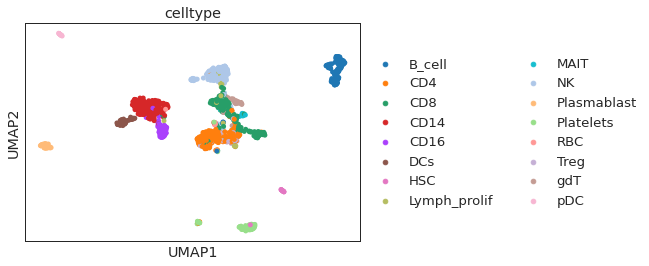

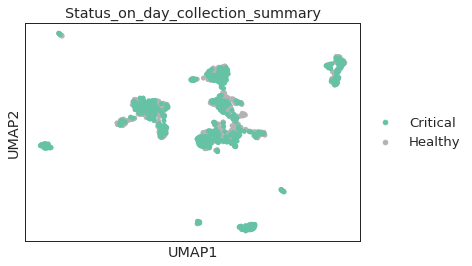

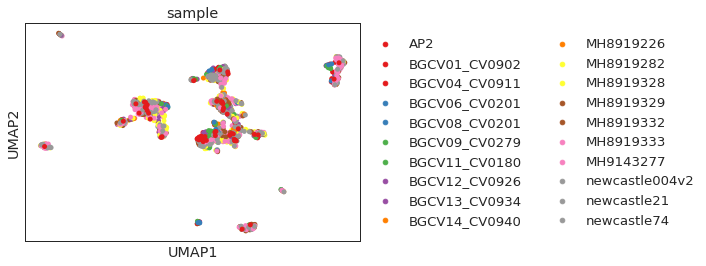

In [44]:
%matplotlib inline
sc.pl.umap(ad, color='celltype', s=100)
sc.pl.umap(ad, color='Status_on_day_collection_summary', palette='Set2', s=100)
sc.pl.umap(ad, color='sample', palette='Set1', s=100)


## Compute SEA2Cells

We perform another round of SEACell aggregation in order to facilitate comparisons across patients. Since the datasets are already highly summarized and contain relatively few samples, we will search for 1 SEA2Cell for every 10 SEACells.

In [95]:
from SEACells.core import SEACells

model = SEACells(ad, 
                  build_kernel_on='X_pca_harmony', 
                  n_SEACells=ad.shape[0]//5, 
                  n_waypoint_eigs=10,
                  convergence_epsilon = 1e-6)

model.fit(n_iter=100)

Building kernel...
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...



Making graph symmetric...
Computing RBF kernel...



Building similarity LIL matrix...



Constructing CSR matrix...
Building kernel on X_pca_harmony
Computing diffusion components from X_pca_harmony for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 163 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...



Selecting 71 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.00032108956667764295
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Starting iteration 30.
Completed iteration 30.
Starting iteration 40.
Completed iteration 40.
Starting iteration 50.
Completed iteration 50.
Converged after 52 iterations.


In [96]:
ad.obs.head()

,sample,# Single Cells,Status_on_day_collection_summary,celltype,SEACell
index,,,,,
CGGACACTCTGCAGTA-MH8919226,MH8919226,84,Healthy,NK,BGCV01_TTCTTAGAGGTCGGAT-1
CGCTTCAGTAAAGTCA-MH8919226,MH8919226,89,Healthy,NK,CCATGTCCACCGCTAG-newcastle74
CACATTTCAATCTGCA-MH8919226,MH8919226,99,Healthy,CD14,TGACAACCACTAAGTC-MH8919282
GGGACCTGTAAGGATT-MH8919226,MH8919226,54,Healthy,B_cell,AGATCTGCAAGTTCTG-MH9143277
AGACGTTAGTGACTCT-MH8919226,MH8919226,36,Healthy,B_cell,ACTGAACCAGGATCGA-MH8919282


In [97]:
SEA2Cell_ad = summarize_by_SEACell(ad, SEACells_label='SEACell')

/Users/sitarapersad/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2492: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [98]:
SEA2Cell_ad.obs['# Single Cells'] = ad.obs.groupby('SEACell').apply(lambda x: x['# Single Cells'].sum()).loc[SEA2Cell_ad.obs_names]
SEA2Cell_ad.obs['celltype'] = ad.obs.groupby('SEACell').apply(lambda x: x['celltype'].mode().iloc[0]).loc[SEA2Cell_ad.obs_names]
SEA2Cell_ad.obs['# Distinct Samples'] = ad.obs.groupby('SEACell').apply(lambda x: len(x['sample'].unique())).loc[SEA2Cell_ad.obs_names]


SEA2Cell_ad.obs.head()


,# Single Cells,celltype,# Distinct Samples
BGCV01_TTCTTAGAGGTCGGAT-1,520,NK,5
CCATGTCCACCGCTAG-newcastle74,415,NK,3
TGACAACCACTAAGTC-MH8919282,444,CD14,5
AGATCTGCAAGTTCTG-MH9143277,802,B_cell,7
ACTGAACCAGGATCGA-MH8919282,346,B_cell,5


In [99]:
sc.pp.normalize_total(SEA2Cell_ad)
sc.pp.log1p(SEA2Cell_ad)
sc.pp.highly_variable_genes(SEA2Cell_ad, n_top_genes=2500, inplace=True)

sc.tl.pca(SEA2Cell_ad, use_highly_variable=True)
sc.pp.neighbors(SEA2Cell_ad, use_rep='X_pca')
sc.tl.umap(SEA2Cell_ad)

... storing 'celltype' as categorical


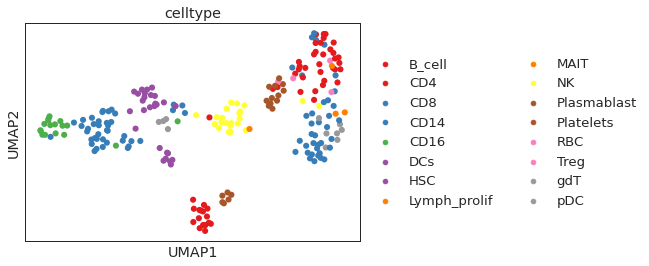

In [100]:
%matplotlib inline
sc.pl.umap(SEA2Cell_ad, color='celltype', palette='Set1', s=150)


# Differentially Expressed Genes per SEA2Cell

In [103]:
celltypes = list(SEA2Cell_ad.obs['celltype'].unique())
celltypes

['NK',
 'CD14',
 'B_cell',
 'CD16',
 'CD8',
 'DCs',
 'Platelets',
 'CD4',
 'MAIT',
 'gdT',
 'pDC',
 'Treg',
 'HSC',
 'RBC',
 'Lymph_prolif',
 'Plasmablast']

In [117]:
def get_differentially_expressed_genes(SEACell_ad, SEA2Cell_ad, celltype):
    """
    @param: SEACell_ad - aggregated anndata containining .obs['SEACell'] assignments
    @param: SEA2Cell_ad - (doubly) aggregated anndata obtaining after applying SEACells to the aforementioned SEACell_ad
    @param: celltype - (str) defining which celltype to subset to."""
    
    tmp_ad = SEA2Cell_ad[SEA2Cell_ad.obs_names[SEA2Cell_ad.obs['celltype']==celltype]]
    SEA2Cells = tmp_ad.obs_names
    print(f'Processing {celltype} containing {tmp_ad.shape[0]} SEA2Cells')
    
    ad = SEACell_ad[SEACell_ad.obs_names[SEACell_ad.obs['SEACell'].isin(SEA2Cells)]]
    
    counts = ad.obs.groupby('SEACell').count().iloc[:,0]
    print(f'Removing {(counts<2).sum()} SEA2Cell(s) of insufficient size')
    SEA2Cells = counts[counts>1].index
    
    ad = SEACell_ad[SEACell_ad.obs_names[SEACell_ad.obs['SEACell'].isin(SEA2Cells)]]
    
    sc.tl.rank_genes_groups(ad, groupby='SEACell', use_raw=False, n_genes=500)

    names = pd.DataFrame(ad.uns['rank_genes_groups']['names'])
    names.columns = pd.MultiIndex.from_product([names.columns, ['names']])
    logFC = pd.DataFrame(ad.uns['rank_genes_groups']['logfoldchanges'])
    logFC.columns = pd.MultiIndex.from_product([logFC.columns, ['logFC']])
    pvals = pd.DataFrame(ad.uns['rank_genes_groups']['pvals'])
    pvals.columns = pd.MultiIndex.from_product([pvals.columns, ['pvals']])

    df = pd.concat([names, logFC, pvals], axis=1)

    return df
        
        

In [118]:
celltypes = ['CD4']

for celltype in celltypes:   
    df = get_differentially_expressed_genes(ad, SEA2Cell_ad, celltype)

/Users/sitarapersad/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2492: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/sitarapersad/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2492: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/Users/sitarapersad/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'SEACell' as categorical


Processing CD4 containing 34 SEA2Cells
Removing 1 SEA2Cell(s) of insufficient size


In [119]:
df.head()

,AAACCTGAGACTTTCG-newcastle74,AACACGTAGGTGATAT-newcastle21,AACTGGTCAGTAACGG-MH8919282,AGGTCATCACGCGAAA-MH9143277,ATCTACTTCTTGTACT-MH8919282,BGCV06_CTAATGGGTTACGTCA-1,BGCV06_GTTTCTATCAGAGGTG-1,BGCV09_TGAGGGATCCAAGCCG-1,BGCV11_GCATGATGTCTTTCAT-1,BGCV12_CTCTGGTGTCGGGTCT-1,...,GCACATAGTCTGATCA-MH8919282,GGACATTAGAGAGCTC-newcastle21,S14_AAGTCTGGTGTGCGTC-1,S14_CAGAATCCAGTCCTTC-1,S14_TTATGCTAGCCAGTTT-1,TAGGCATCACTGAAGG-MH8919282,TAGTGGTCAAGTACCT-MH8919332,TCACGAATCAGTCCCT-MH8919332,TCGTACCGTTCCGGCA-newcastle004v2,TGCTACCGTAGTACCT-MH8919328
,names,names,names,names,names,names,names,names,names,names,...,pvals,pvals,pvals,pvals,pvals,pvals,pvals,pvals,pvals,pvals
0,UBL5,HSD11B1L,CRIP1,AC020916.1,PERP,SELP,RPL41,MTRNR2L12,NENF,RTP5,...,3.726212e-09,3.832994e-11,3.023058e-14,1.464674e-16,5.838909e-43,2.237653e-27,4.526806e-18,2.067718e-10,2.349263e-24,1.501368e-09
1,CCS,TRBV12-2,EVI2B,LGALS1,SNAI3,GAS2L1,MTRNR2L12,AC016831.6,CMPK1,LYAR,...,2.374137e-06,2.771775e-21,3.099532e-05,6.091794e-16,1.982766e-40,4.455021e-29,3.189823e-08,3.000378e-12,1.657138e-169,5.983901e-10
2,PPDPF,ZNF8,RPS10-NUDT3,ARPC4,AL627171.2,ITGA2B,CMPK1,KLF2,NFKB1,ADRB2,...,2.778837e-08,2.318445e-47,1.500260e-05,5.028129e-15,8.521990e-40,7.545856e-17,7.622544e-09,5.112827e-09,9.156308e-165,4.823851e-09
3,MT-ATP6,TRUB2,ANXA1,PLP2,ABCB1,SCN1B,PCBP2,RPL41,SRM,BHLHE40,...,3.576270e-07,4.655706e-09,2.254259e-05,2.343787e-06,4.142374e-13,9.356126e-60,1.231673e-09,2.108763e-06,2.703965e-30,6.198307e-11
4,ELOB,C1orf50,TAGLN2,PHLDA1,MMP25,AL591167.1,CTU1,PCBP1,PTOV1,MTRNR2L12,...,2.292615e-07,3.353232e-36,4.216011e-05,1.332140e-20,5.842660e-37,5.998587e-18,1.949595e-07,5.928478e-06,2.865853e-28,4.019908e-09
